# Image extraction from JSON

In [ ]:
#Meter pip installs para aqui

In [4]:
#!pip install transformers
#!pip install git+https://github.com/openai/CLIP.git

Traceback (most recent call last):
  File "/opt/jupyterhub/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
  File "/opt/jupyterhub/lib/python3.8/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/opt/jupyterhub/lib/python3.8/site-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/opt/jupyterhub/lib/python3.8/site-packages/pip/_internal/cli/main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "/opt/jupyterhub/lib/python3.8/site-packages/pip/_internal/cli/cmdoptions.py", line 25, in <module>
    from pip._internal.locations import USER_CACHE_DIR, get_src_prefix
  File "/opt/jupyterhub/lib/python3.8/site-packages/pip/_internal/locations.py", line 19, in <module>
    from pip._internal.utils import appdirs
  File "/opt/jupyterhub/lib/python3.8/site-packages/p

In [1]:
import json as json


with open("recipes_data.json", "r") as read_file: #mudar o caminho depois so para o json
    data = json.load(read_file)

images = []

for x in data:
  recipe_id = x
  principal_images = data[str(x)]['images']
  for z in range (len(principal_images)):
    images.append(principal_images [z]['url'])
  instructions = data[str(x)] ['instructions']
  for u in range (len(instructions)):
    stepImages = instructions [u] ['stepImages']
    for a in range (len(stepImages)):
      images.append(stepImages[a]['url'])
    
print (len(images))

1801


# Open all the images - Run this code only when necessary

In [2]:
from PIL import Image
import requests

import clip

model, preprocess = clip.load("ViT-B/32")

images_open = []
for x in range(len(images)):#range(len(images)): #mudar range para o de todas as imagens quando correr no cluster
  ipanema = Image.open(requests.get(images[x], stream=True).raw)
  images_open.append(preprocess(ipanema))

In [14]:
print(len(images_open))

1801


# Calculate image_features - Run this code only when necessary

In [3]:
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import numpy as np



#with torch.no_grad():
      #  photo_preprocessed = processor(text=None, images=images_open, return_tensors="pt", padding=True)["pixel_values"]
       # image_features = model.get_image_features(photo_preprocessed.to(device))
        #image_features /= image_features.norm(dim=-1, keepdim=True)
image_input = torch.tensor(np.stack(images_open))#.cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
image_features /= image_features.norm(dim=-1, keepdim=True)



# Choose the best image

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [5]:
from IPython.display import Image as im2

def similarity(feature, photo_features):
  similarities = list((feature @ photo_features.T).squeeze(0))
  return similarities

def bestImage (text):
    with torch.no_grad():
    # Encode and normalize the description using CLIP
      inputs = tokenizer([text[0:76]],  padding=True, return_tensors="pt")
      inputs = processor(text=[text[0:76]], images=None, return_tensors="pt", padding=True)
    text_encoded =  model.get_text_features(**inputs).detach().numpy()

    similarities = similarity(text_encoded, image_features.cpu().numpy())
  
    bestphoto_idx = sorted(zip(similarities, range(image_features.shape[0])), key=lambda x: x[0], reverse=True) [0] [1]
    #o return pode ser um img show para mostrar logo a imagem, por enquanto estamos a retornar o url
    return images[bestphoto_idx]

#p = bestImage("cut the chicken")
#im2(p)
#Place the chicken, perched on its beer can throne, on the cool side of the grill. Close the grill lid and leave the chicken to cook for 1 hour \u2014 resist the urge to open the lid and check. Just leave it alone!



# Show recipe steps with images

In [6]:
def showStepsUrl (id):
  recipe = data[str(id)]
  print("Recipe name: " + recipe['displayName'])
  steps = recipe['instructions']
  for l in range(len(steps)):
    print("Step number: "+ str(steps[l]['stepNumber']))
    stepText = steps[l]['stepText']
    print(stepText)
    if(len(steps[l]['stepImages']) == 0):
      url = bestImage(stepText)
    else:
      url = steps[l]['stepImages'][0]['url']
    print(url)
    im2(url)

showStepsUrl(30) 

Recipe name: Yellow Curry Shrimp
Step number: 1
Prepare the Basmati Rice according to package's instructions.
https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/sidechef/c5a4e60c3904198ed8e706a6aba99068798e90d4fe2d175eeae4342305b23ccc.jpeg
Step number: 2
Parboil Yukon Gold Potato and Sweet Potato. Parboil means to partially cook in boiling water. Season a pot of cold water with plenty of kosher salt (1/2 tsp) and cook the potatoes until they are partially cooked, but not yet fork-tender​.
https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/allrecipes/14929129f184315cf942913a0ddf030ca99e539c66ea0c2f7ceeef8147f423e3.jpg
Step number: 3
Peel and devein the Medium Shrimp. Rinse them and set aside in the refrigerator until you need them.
https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/sidechef/b1bee8dea719a71742fed4ae3a0ee698e9d3c42f389b575ba354e1aa1cddadfc.jpg
Step number: 4
In a food processor, puree the Garlic, Fresh Ginger, Onion

In [18]:
from IPython.display import Image, HTML, display
def showStepsImage (id):
  recipe = data[str(id)]
  display(HTML(f"""
    <div class ="row" style="margin-left:100px">
       <b>Recipe name: {recipe['displayName']}
       <br><br>
    """))
  steps = recipe['instructions']
  for l in range(len(steps)):
    display(HTML(f"""
    <div class =  "steps">
       <b>Step Number: </b> {str(steps[l]['stepNumber'])}
    """))
    stepText = steps[l]['stepText']
    display(HTML(f"""
    <div class = "stepText">
       <b>Step Text:</b> {stepText}
    """))
    if(len(steps[l]['stepImages']) == 0):
      url = bestImage(stepText)
    else:
      url = steps[l]['stepImages'][0]['url']
    display(HTML(f"""
      <div class = "stepImage">
       <img src="{url}" class="img-responsive" width="300" heigth ="400">
       <br><br>
    """))


showStepsImage(30)

# Questions for the project

In [59]:
import numpy as np
import pprint
from transformers import BertTokenizer, BertModel
from transformers import *
import torch
from sklearn.decomposition import PCA



%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

model_path = 'bert-base-uncased'
CLS_token = "[CLS]"
SEP_token = "[SEP]"

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config)

def display_scatterplot(model, words,tlt):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
    plt.figure(figsize=(6,6))
    plt.title(tlt)
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

    return


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /user/home/user213/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncas

## Contextual embeddings
Visualize the contextual word embeddings from layer 0 to layer 11. Observe how they change from layer to layer

In [61]:
sentence_a = "Is throat cancer treatable nowadays?"
sentence_b = "Tell me about lung cancer."
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
pprint.pprint(inputs)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[  101,  2003,  3759,  4456,  7438,  3085, 13367,  1029,   102,  2425,
          2033,  2055, 11192,  4456,  1012,   102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])}


In [62]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
pprint.pprint(tokens)

['[CLS]',
 'is',
 'throat',
 'cancer',
 'treat',
 '##able',
 'nowadays',
 '?',
 '[SEP]',
 'tell',
 'me',
 'about',
 'lung',
 'cancer',
 '.',
 '[SEP]']


In [63]:
with torch.no_grad():
    outputs = model(**inputs)

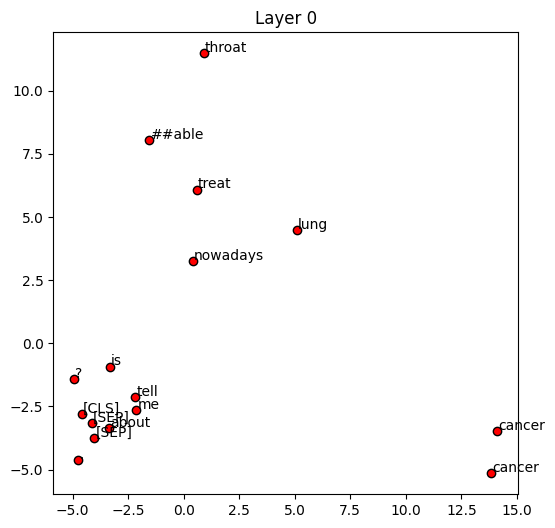

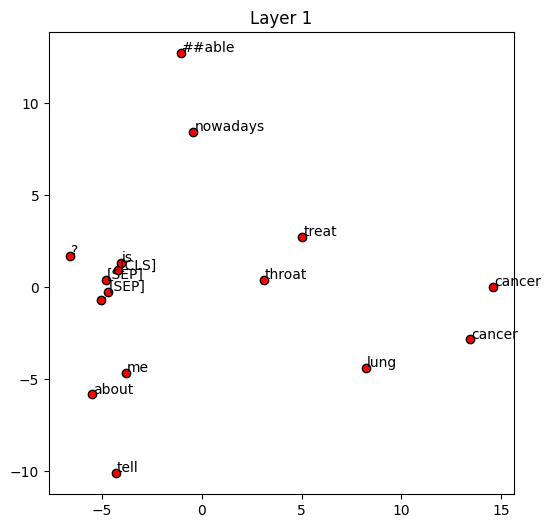

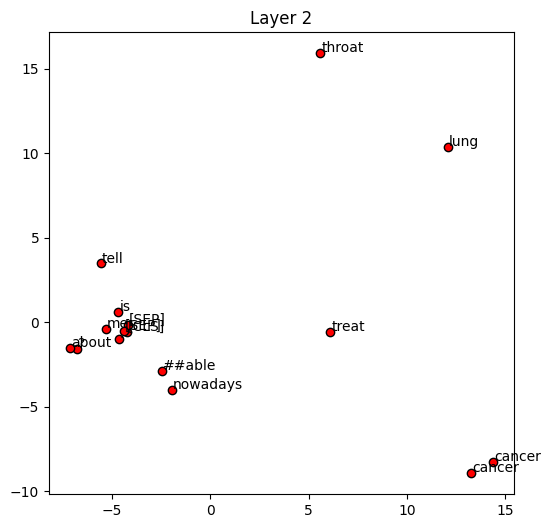

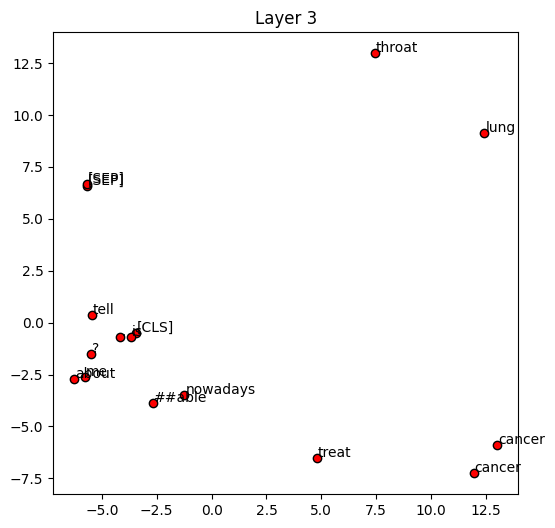

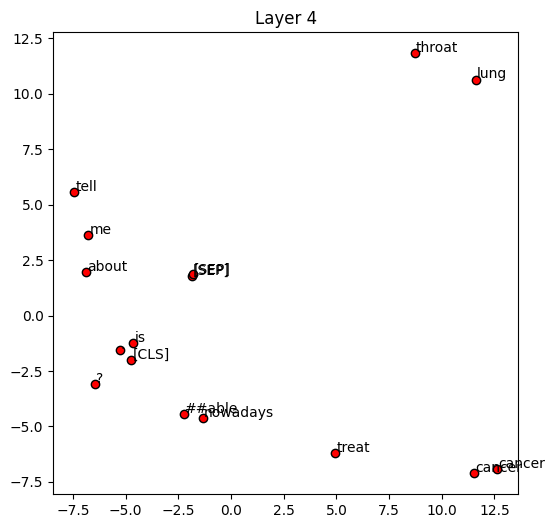

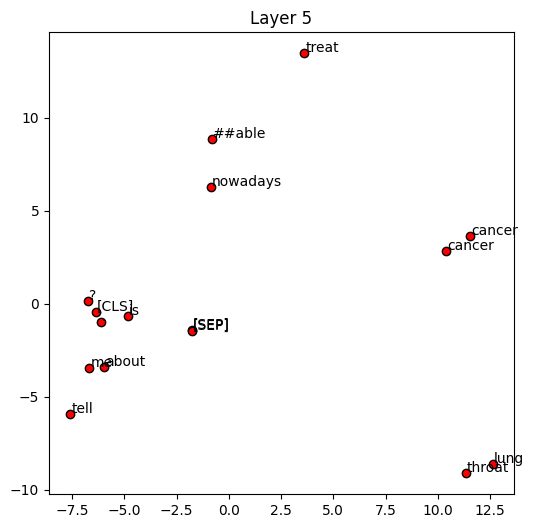

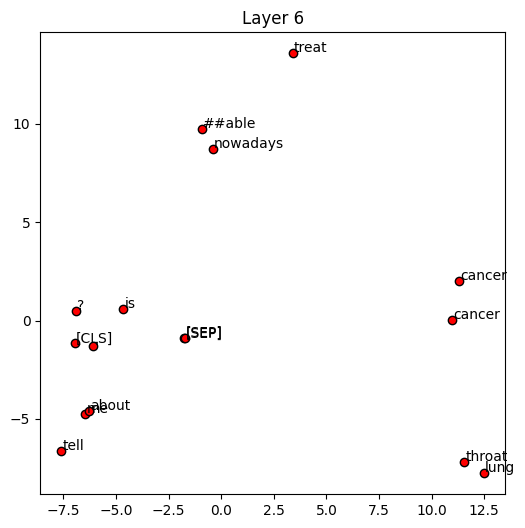

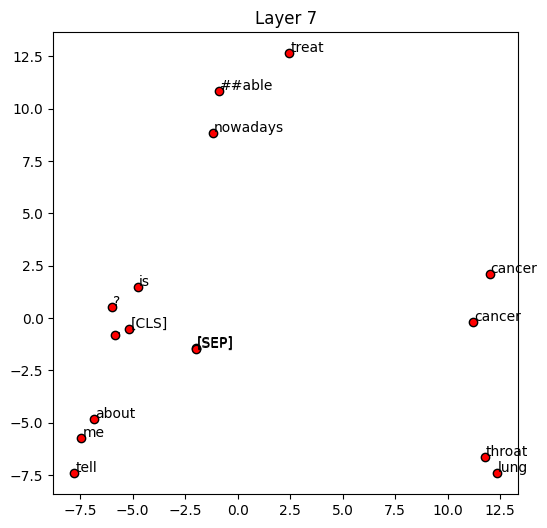

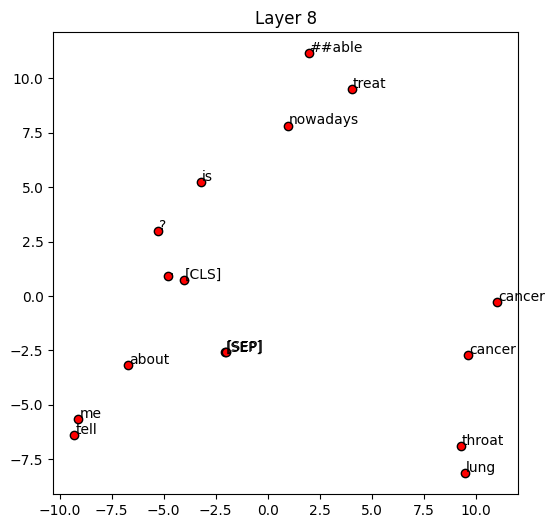

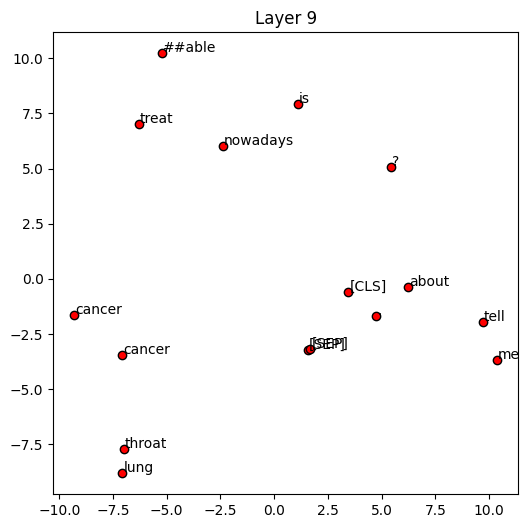

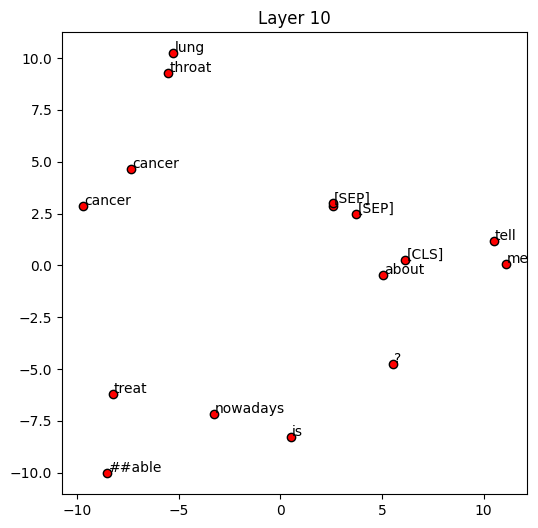

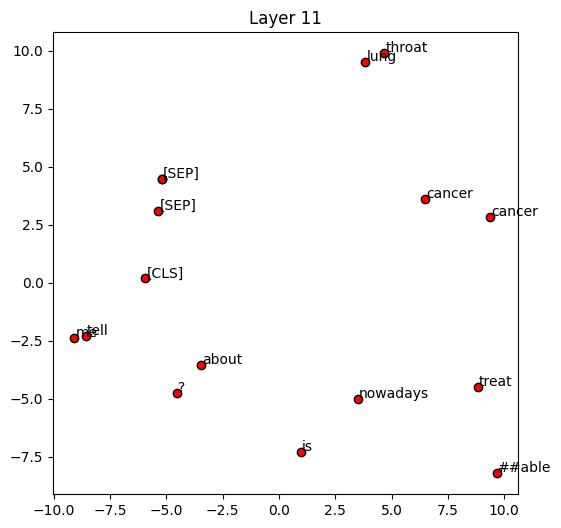

In [64]:
for n in range (12):
    emb = outputs['hidden_states'][n][0]
    display_scatterplot(emb.detach().numpy(), tokens, "Layer " + str(n))

## Positional Embeddings
Consider a simple BERT encoder. Insert a sequence of text with the same word repeated 20 times. Visualize and examine the embeddings and discuss what you observed.

In [65]:
sentence_c = "dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog"
inputsc = tokenizer.encode_plus(sentence_c, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
pprint.pprint(inputsc)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[ 101, 3899, 3899, 3899, 3899, 3899, 3899, 3899, 3899, 3899, 3899, 3899,
         3899, 3899, 3899, 3899, 3899, 3899, 3899, 3899, 3899,  102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [66]:
input_idsc = inputsc['input_ids']
input_id_listc = input_idsc[0].tolist() # Batch index 0
tokensc = tokenizer.convert_ids_to_tokens(input_id_listc)
pprint.pprint(tokensc)

['[CLS]',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 '[SEP]']


In [67]:
with torch.no_grad():
    outputsc = model(**inputsc)

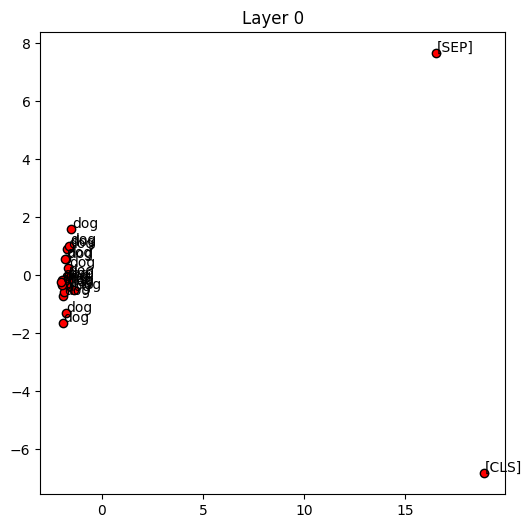

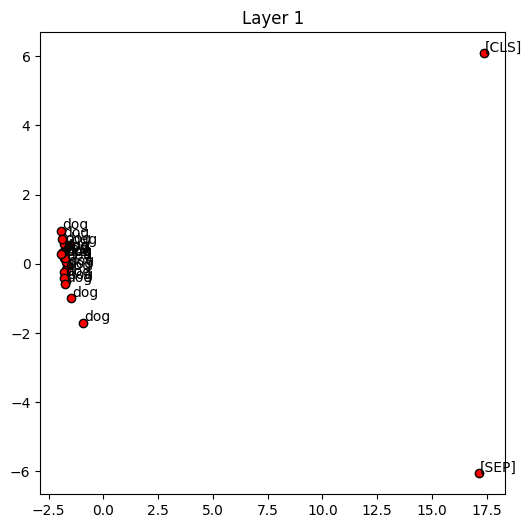

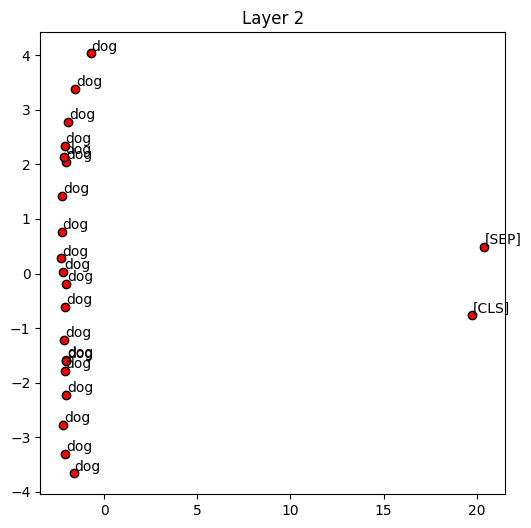

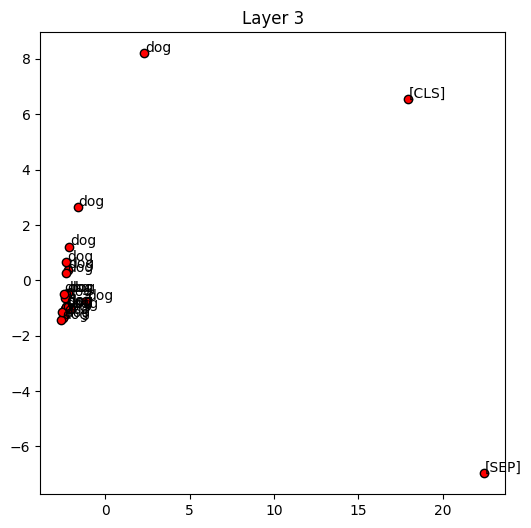

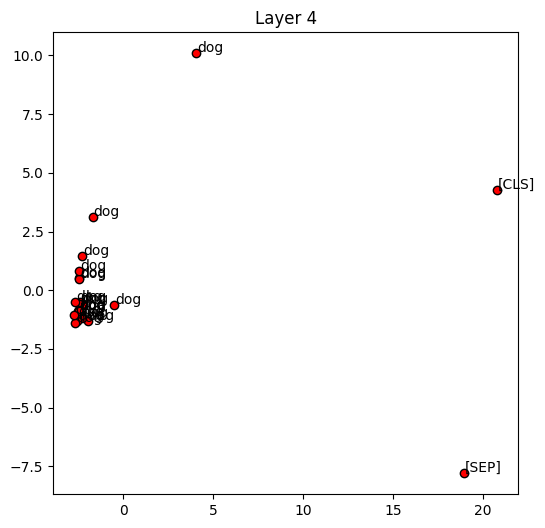

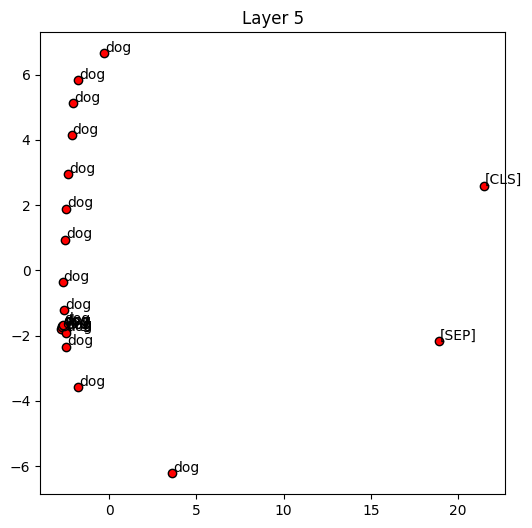

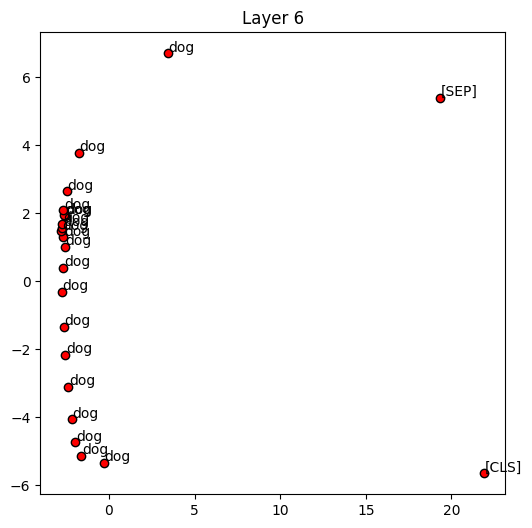

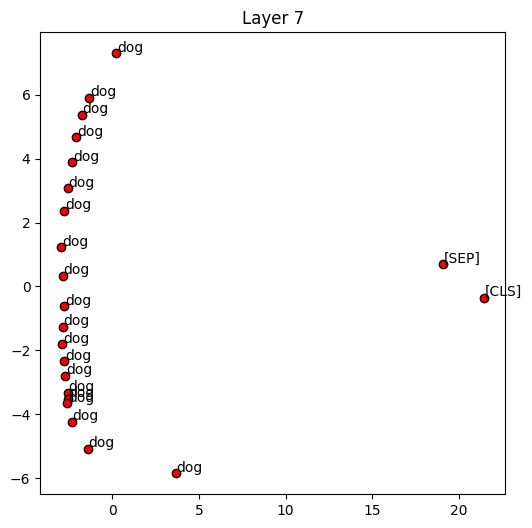

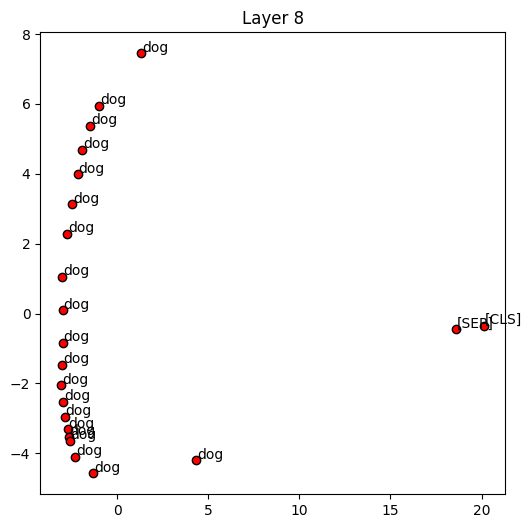

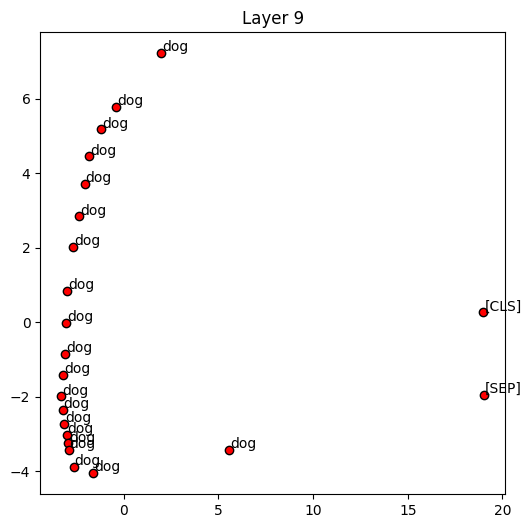

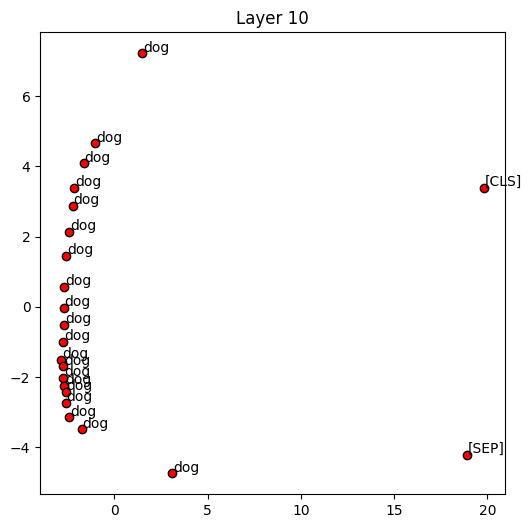

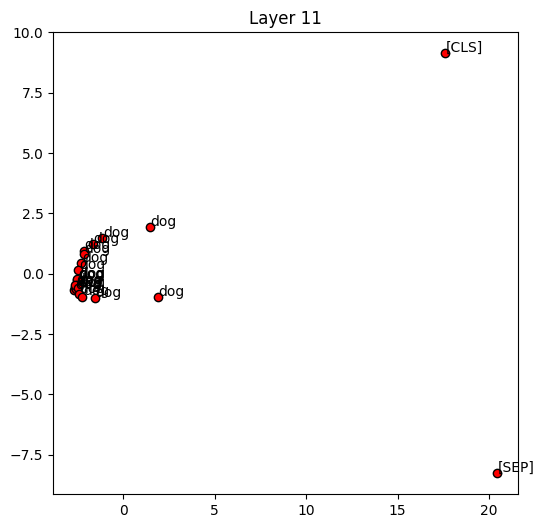

In [9]:
for n in range (12):
    embc = outputsc['hidden_states'][n][0]
    display_scatterplot(embc.detach().numpy(), tokensc, "Layer " + str(n))

## Sentence embeddings
Consider the sentence algorithms. Examine the provided implementation and explain the sentence embeddings in terms of output embeddings

In [68]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from torch import Tensor

#Mean Pooling - Take average of all tokens
def mean_poolingS(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encodeS(texts):
    # Tokenize sentences
    encoded_input = tokenizerS(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = modelS(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_poolingS(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings

#Calculate similarity
def cos_sim(a: Tensor, b: Tensor):
    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

# Load model from HuggingFace Hub
tokenizerS = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")
modelS = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")

loading configuration file https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v2/resolve/main/config.json from cache at /user/home/user213/.cache/huggingface/transformers/71ddac4e18eb10643cb6e726d02d16d2c2f00f7290887da429474360d171599e.7dad816b5e3ee5a1e83ff7a459177600525804aa8116670a29788b69422c015a
Model config DistilBertConfig {
  "_name_or_path": "sentence-transformers/msmarco-distilbert-base-v2",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v2/resolve/main/vocab.txt

In [69]:
firstSentence = encodeS("I'm sad")
secondSentence = encodeS("I'm sad")
cos_sim(firstSentence, secondSentence)

tensor([[1.0000]])

## Self-Attention
Examine the self-attention mechanism of a transformer cross-encoder. Repeat with a dual encoder. Do critical analysis of your observations

In [70]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
#!rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [71]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

### Cross encoder

In [72]:
from bertviz import model_view, head_view
attention = outputs['attentions']
# The format of the attention tensor is:
# attention[layer][0][head][token1][token2]
#call_html()
#head_view(attention, tokens)

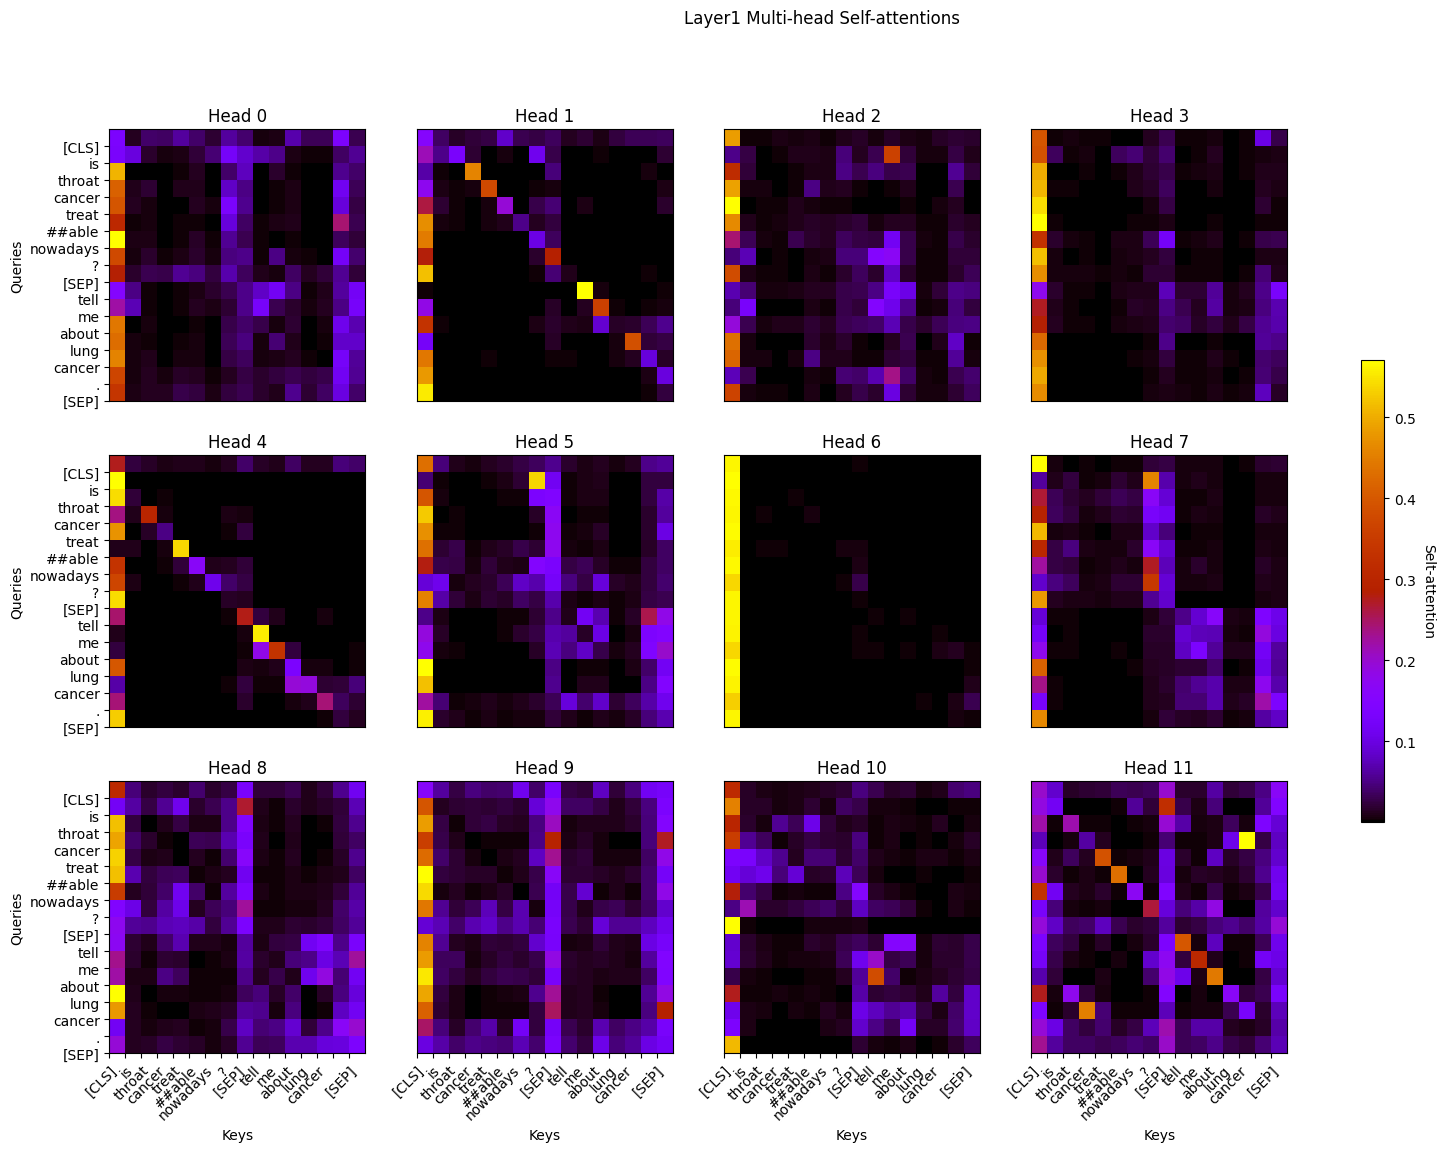

In [74]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        sattention = attention[layer][0][j].numpy()
        sattention = np.flip(sattention, 0)
        
        plt.rcParams.update({'font.size': 10})

        im = ax.pcolormesh(sattention, cmap='gnuplot')

        # Show all ticks and label them with the respective list entries
        ax.set_title("Head " + str(j))
        ax.set_yticks(np.arange(len(tokens)))
        if c == 0:
            ax.set_yticklabels(reversed(tokens))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        ax.set_xticks(np.arange(len(tokens)))
        if r == rows-1:
            ax.set_xticklabels(tokens)
            ax.set_xlabel("Keys")
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
        else:
            ax.set_xticks([])

            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()

### Dual Encoder

In [106]:
inputs_a_dual = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
inputs_b_dual = tokenizer.encode_plus(sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
with torch.no_grad():
    outputs_a_dual = model(**inputs_a_dual)
    outputs_b_dual = model(**inputs_b_dual)
input_ids_a_dual = inputs_a_dual['input_ids']
input_id_list_a_dual = input_ids_a_dual[0].tolist() # Batch index 0
tokens_a_dual = tokenizer.convert_ids_to_tokens(input_id_list_a_dual)
input_ids_b_dual = inputs_b_dual['input_ids']
input_id_list_b_dual = input_ids_b_dual[0].tolist() # Batch index 0
tokens_b_dual = tokenizer.convert_ids_to_tokens(input_id_list_b_dual)
tokensTotal = tokens_a_dual + tokens_b_dual
print(tokens_a_dual)

['[CLS]', 'is', 'throat', 'cancer', 'treat', '##able', 'nowadays', '?', '[SEP]']


In [120]:
attention_a_dual = outputs_a_dual['attentions']
attention_b_dual = outputs_b_dual['attentions']
result = attention_b_dual + attention_a_dual

AttributeError: 'tuple' object has no attribute 'T'

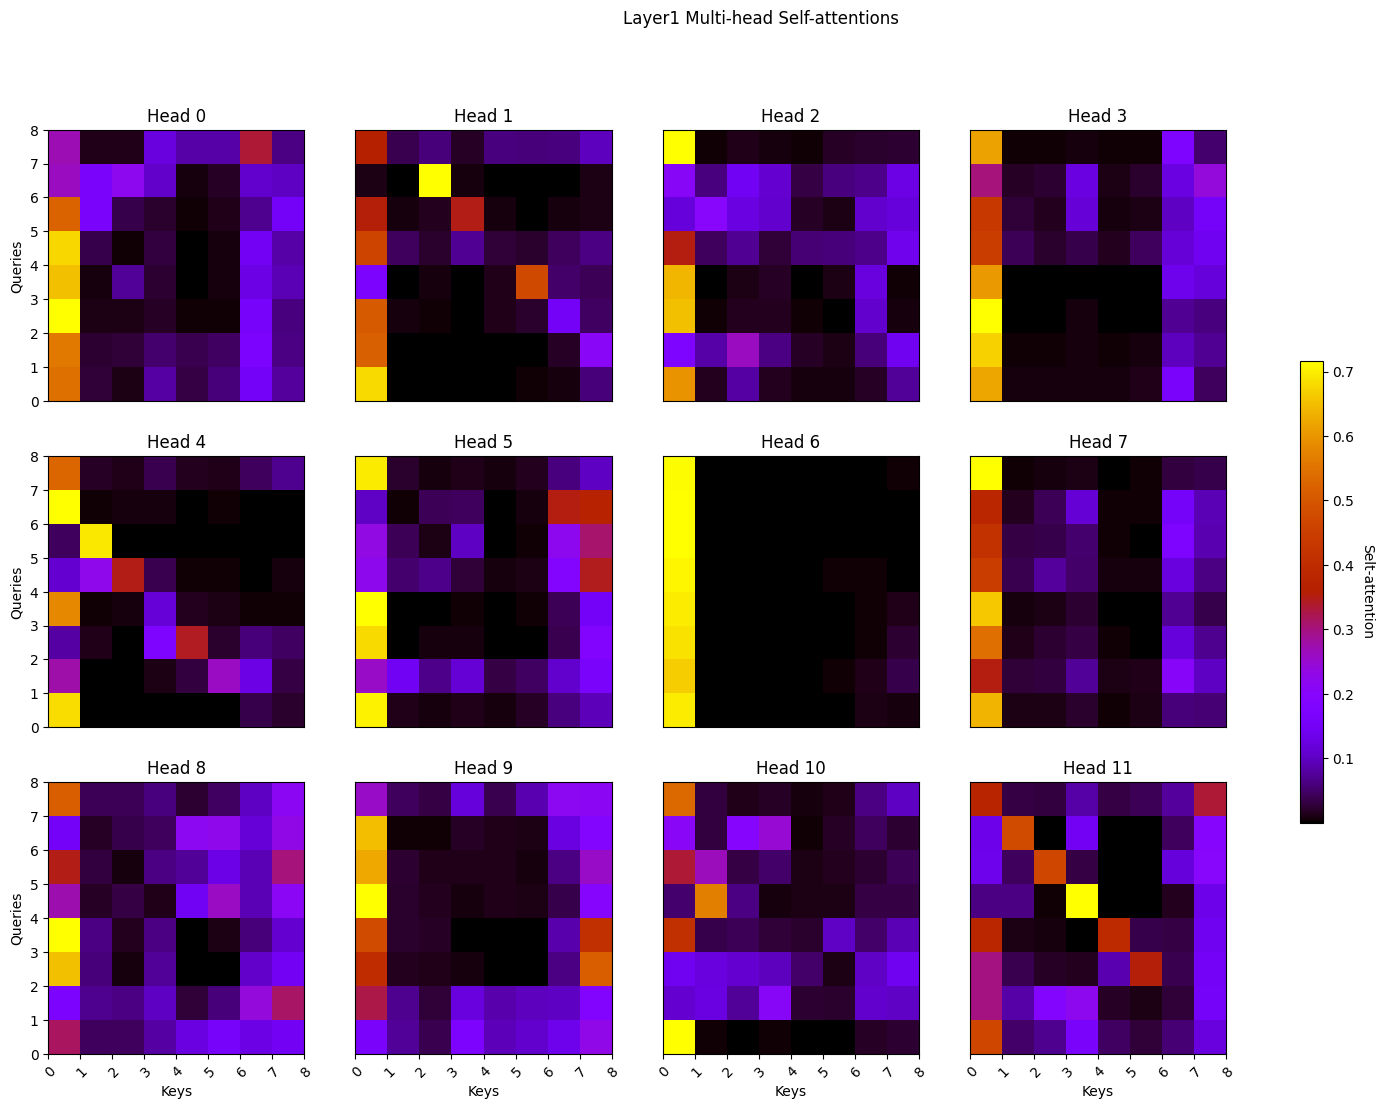

In [125]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        sattention2 = result[layer][0][j].numpy()
        sattention2 = np.flip(sattention2, 0)
        
        plt.rcParams.update({'font.size': 10})

        im = ax.pcolormesh(sattention2, cmap='gnuplot')

        # Show all ticks and label them with the respective list entries
        ax.set_title("Head " + str(j))
        ax.set_yticks(np.arange(len(tokensTotal)/2))
        if c == 0:
            #ax.set_yticklabels(reversed(tokensTotal))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        ax.set_xticks(np.arange(len(tokensTotal)/2))
        if r == rows-1:
            #ax.set_xticklabels(tokensTotal)
            ax.set_xlabel("Keys")
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
        else:
            ax.set_xticks([])

            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()

## Vision and Language Self-Attention
Visualize the self-attention with vision and language data. Do a critical analysis of your observations

In [89]:
from transformers import ViltProcessor, ViltForQuestionAnswering, AutoTokenizer, AutoConfig
import requests

model_pathVQ = "dandelin/vilt-b32-finetuned-vqa"

configVQ = AutoConfig.from_pretrained(model_pathVQ,  output_hidden_states=True, output_attentions=True)  
processorVQ = ViltProcessor.from_pretrained(model_pathVQ)
modelVQ = ViltForQuestionAnswering.from_pretrained(model_pathVQ, config=configVQ)

loading configuration file https://huggingface.co/dandelin/vilt-b32-finetuned-vqa/resolve/main/config.json from cache at /user/home/user213/.cache/huggingface/transformers/b4b390f7163902726a6409afda3cf54d03f1359472acf57534d922e9732d94a3.9db4b7be3cbacc2f07823f7bfe48d65404e6056a8368062908091dfad68e1cfd
Model config ViltConfig {
  "_name_or_path": "dandelin/vilt-b32-finetuned-vqa",
  "architectures": [
    "ViltForVisualQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "net",
    "1": "pitcher",
    "2": "orange",
    "3": "yes",
    "4": "white",
    "5": "skiing",
    "6": "red",
    "7": "frisbee",
    "8": "brushing teeth",
    "9": "no",
    "10": "black and white",
    "11": "skateboard",
    "12": "1",
    "13": "blue",
    "14": "green",
    "15": "motorcycle",
    "16": "gray",
    "17": "2",
    "18": "purse",
    "19": "skis",
    "20": "poles",
    "21": "surfboard

In [91]:
from PIL import Image
# prepare image + question
url_a = 'https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/sidechef/c5a4e60c3904198ed8e706a6aba99068798e90d4fe2d175eeae4342305b23ccc.jpeg'
image = Image.open(requests.get(url_a, stream=True).raw)
question = "Which food is this?"
VQ_encoding = processorVQ(image, question, return_tensors="pt")

Which food is this?
Predicted answer: rice


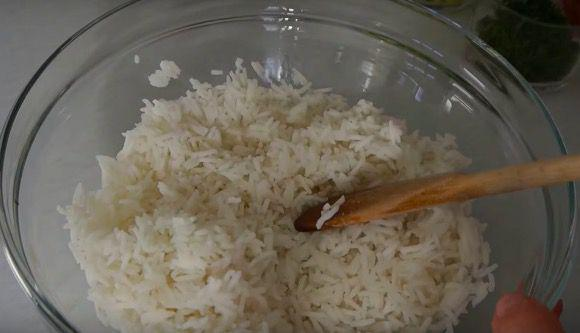

In [94]:
outputsVQ = modelVQ(**VQ_encoding, return_dict = True)
logits = outputsVQ.logits
idx = logits.argmax(-1).item()
print(question)
print("Predicted answer:", modelVQ.config.id2label[idx])
from IPython.display import Image
Image(url_a)

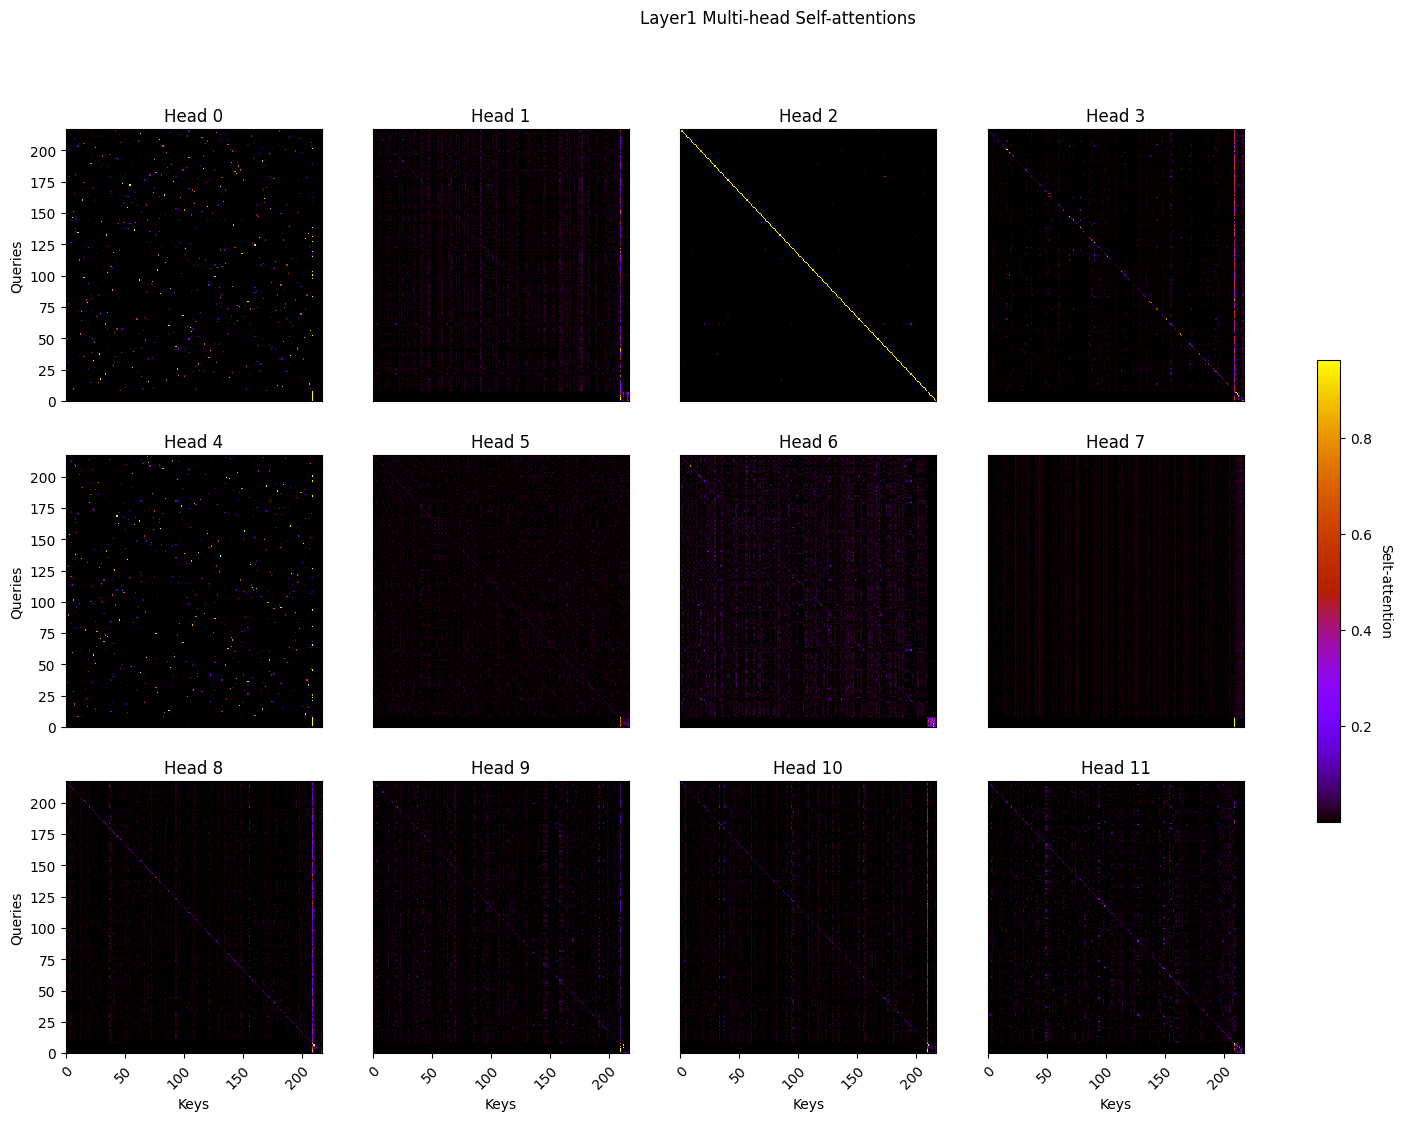

In [102]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        sattention3 = outputsVQ['attentions'][layer][0][j].detach().numpy()
        sattention3 = np.flip(sattention3, 1)
        
        plt.rcParams.update({'font.size': 10})

        im = ax.pcolormesh(sattention3, cmap='gnuplot')

        # Show all ticks and label them with the respective list entries
        ax.set_title("Head " + str(j))
        #ax.set_yticks(np.arange(len(tokensTotal)))
        if c == 0:
            #ax.set_yticklabels(reversed(tokensTotal))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        #ax.set_xticks(np.arange(len(tokensTotal)))
        if r == rows-1:
            #ax.set_xticklabels(tokensTotal)
            ax.set_xlabel("Keys")
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
        else:
            ax.set_xticks([])

            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()